# Ben is my best friend

### Load code libraries that we'll need

In [1]:
%matplotlib inline

In [2]:
# Native python libraries
import datetime
import os

# Third party libraries
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
sns.set_theme()

### Store all the URLs for all the states using this website format

In [3]:
URLS = {
  'AK': 'https://www.golfalaska.com/golfcourses/results.cfm?startrow=',    
  'AL': 'https://www.golfalabama.com/golfcourses/results.cfm?startrow=',
  'AZ': 'https://www.arizonagolfer.com/golfcourses/results.cfm?startrow=',
  'AR': 'https://www.arkansasgolf.com/golfcourses/results.cfm?startrow=',
  'CA': 'https://www.cagolf.com/golfcourses/results.cfm?startrow=',
  'CO': 'https://www.golfingcolorado.com/golfcourses/results.cfm?startrow=',
  'CT': 'https://www.connecticutgolf.com/golfcourses/results.cfm?startrow=',
  'DE': 'https://www.golfdelaware.com/golfcourses/results.cfm?startrow=',
  'DC': 'https://www.dcgolf.com/golfcourses/results.cfm?startrow=',
  'FL': 'https://www.floridagolfer.com/golfcourses/results.cfm?startrow=',
  'GA': 'https://www.golfinggeorgia.com/golfcourses/results.cfm?startrow=',
  'HI': 'https://www.hawaiigolfcourses.com/golfcourses/results.cfm?startrow=',
  'ID': 'https://www.idahogolf.com/golfcourses/results.cfm?startrow=',
  'IL': 'https://www.illinoisgolf.com/golfcourses/results.cfm?startrow=',
  'IN': 'https://www.indianagolf.com/golfcourses/results.cfm?startrow=',
  'IA': 'https://www.iowagolf.com/golfcourses/results.cfm?startrow=',
  'KS': 'https://www.kansasgolf.com/golfcourses/results.cfm?startrow=',
  'KY': 'https://www.kentuckygolf.com/golfcourses/results.cfm?startrow=',
  'LA': 'https://www.louisianagolf.com/golfcourses/results.cfm?startrow=',
  'ME': 'https://www.mainegolf.com/golfcourses/results.cfm?startrow=',
  'MD': 'https://www.marylandgolf.com/golfcourses/results.cfm?startrow=',
  'MA': 'https://www.golfmassachusetts.com/golfcourses/results.cfm?startrow=',
  'MI': 'https://www.golfmichigan.com/golfcourses/results.cfm?startrow=',
  'MN': 'https://www.minnesotagolf.com/golfcourses/results.cfm?startrow=',
  'MS': 'https://www.golfmississippi.com/golfcourses/results.cfm?startrow=',
  'MO': 'https://www.golfmissouri.com/golfcourses/results.cfm?startrow=',
  'MT': 'https://www.golfingmontana.com/golfcourses/results.cfm?startrow=',
  'NE': 'https://www.golfnebraska.com/golfcourses/results.cfm?startrow=',
  'NV': 'https://www.golfnevada.com/golfcourses/results.cfm?startrow=',
  'NH': 'https://www.newhampshiregolf.com/golfcourses/results.cfm?startrow=',
  'NJ': 'https://www.njgolf.com/golfcourses/results.cfm?startrow=',
  'NM': 'https://www.golfingnewmexico.com/golfcourses/results.cfm?startrow=',
  'NY': 'https://www.nygolf.com/golfcourses/results.cfm?startrow=',
  'NC': 'https://www.ncgolf.com/golfcourses/results.cfm?startrow=',
  'ND': 'https://www.northdakotagolf.com/golfcourses/results.cfm?startrow=',
  'OH': 'https://www.ohiogolf.com/golfcourses/results.cfm?startrow=',
  'OK': 'https://www.golfoklahoma.com/golfcourses/results.cfm?startrow=',
  'OR': 'https://www.golforegon.com/golfcourses/results.cfm?startrow=',
  'PA': 'https://www.pennsylvaniagolfer.com/golfcourses/results.cfm?startrow=',
  'RI': 'https://www.rhodeislandgolf.com/golfcourses/results.cfm?startrow=',
  'SC': 'https://www.scgolf.com/golfcourses/results.cfm?startrow=',
  'SD': 'https://www.southdakotagolf.com/golfcourses/results.cfm?startrow=',
  'TN': 'https://www.golftennessee.com/golfcourses/results.cfm?startrow=',
  'TX': 'https://www.texasgolf.com/golfcourses/results.cfm?startrow=',
  'UT': 'https://www.utahgolf.com/golfcourses/results.cfm?startrow=',
  'VT': 'https://www.golfvermont.com/golfcourses/results.cfm?startrow=',
  'VA': 'https://www.golfvirginia.com/golfcourses/results.cfm?startrow=',
  'WA': 'https://www.washingtongolf.com/golfcourses/results.cfm?startrow=',
  'WV': 'https://www.golfwestvirginia.com/golfcourses/results.cfm?startrow=',
  'WI': 'https://www.golfwisconsin.com/golfcourses/results.cfm?startrow=',
  'WY': 'https://www.golfwyoming.com/golfcourses/results.cfm?startrow=',
}

OUTPUT_FILENAME = 'all_courses.csv'

### Helper functions

In [4]:
# Given a direct url to a single course's information page, find and return the phone number.
def get_course_phone(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    elt = soup.find_all('h4')[0]  # The first h4 is the one we want
    lines = elt.text.splitlines()
    for line in lines:
        line = line.strip()  # Remove whitespace
        if line.startswith('Phone:'):
            # Will look like: 'Phone: 270-646-4653'
            return line.split()[1]  # Return everything after the first space

In [5]:
# Return data for (up to) 20 golf courses on the given website, starting with course number "row_start"
def get_page(base_url, row_start, data):
    url = base_url + str(row_start)

    # Try to fetch the page three times, in case a request fails
    response = None
    tries = 3
    while tries > 0:
        tries -= 1
        try:
            response = requests.get(url)
            break
        except requests.exceptions.RequestException as e:
            print()
            print(e)
            if tries > 0:
                print(f'Exception. Retrying {tries} more times...')
            else:
                # Reraise error, halting the code
                raise

    # From 'https://www.kentuckygolf.com/golfcourses/results.cfm?startrow='
    # extract the substring, 'https://www.kentuckygolf.com/golfcourses/'
    # We'll use this to fetch individual course phone numbers later.
    root_url = url.split('results.cfm')[0]

    # Find all the golf course information blocks, which are identified by
    # an <h4> tag with an <a> nested inside it (which has the course name
    # and a link to its website). We are looking for things like:
    # <h4><a href="../golfcourses/barren-river-lake-golf-course">Barren River Lake State Resort Park</a></h4>
    soup = BeautifulSoup(response.text)
    headers = soup.find_all('h4')
    filtered_headers = []
    for elt in headers:
        if elt.find('a'):
            filtered_headers.append(elt)

    results = []
    if not filtered_headers:
        return results, False
    all_fetched_before = True
    for i, elt in enumerate(filtered_headers):
        url = elt.find('a').attrs['href']  # Will look like '../golfcourses/barren-river-lake-golf-course'
        url = root_url + url.split('/golfcourses/')[1]  # Extract 'barren-river-lake-golf-course'
        if url in data['url'].values:
            # Already fetched this one
            print(f'#{i + row_start}✓', end=' ')
            continue
        all_fetched_before = False
        print(f'#{len(results) + row_start}', end=' ')
        name = elt.text.strip()  # Remove whitespace
        address = elt.findNext('p').findNext('p').text  # Address is listed two <p> tags later
        address = ' '.join(address.split())  # Remove interstitial white space
        phone = get_course_phone(url)  # Load the course page and find the phone number
        results.append([name, address, phone, url])
    print()
    return results, all_fetched_before

In [6]:
def extract_zip(address):
    # '3651 OMalley Rd Anchorage, AK 99516' -> 99516
    if isinstance(address, str):
        zipcode = address.split()[-1]
        if zipcode.isdigit():
            return int(zipcode)
        return None
    return None

In [7]:
def create_time_delta(t1, t2):
    dt = t2 - t1
    seconds = dt.seconds + dt.days*24*60*60
    hours = seconds // 3600
    seconds = seconds % 3600
    minutes = seconds // 60
    seconds = seconds % 60
    return f'[{hours}:{minutes:02d}:{seconds:02d}]'

### Fetch each state's data, saving as we go

In [ ]:
if os.path.exists(OUTPUT_FILENAME):
    data = pd.read_csv(OUTPUT_FILENAME)
else:
    data = pd.DataFrame([], columns=['name', 'address', 'state', 'zip', 'phone', 'url'])

current_state = ''
if len(data) > 0:
    current_state = max(data['state'])
    print("Current state:", current_state)
else:
    print("Starting fresh")

start_time = datetime.datetime.now()
# Loop through each state and URL pair
states_alphabetical = sorted(URLS.keys())
for state in states_alphabetical:
    if state < current_state:
        nfetched = sum(data['state'] == state)
        assert nfetched > 0, f'Trying to skip {state} but there is no data for it yet?'
        print(f'(Already fetched everything for {state} - {nfetched} courses)')
        continue
    url = URLS[state]
    print('Fetching courses for:', state)
    row = 1
    state_start = datetime.datetime.now()
    courses_before = sum(data['state'] == state)
    while True:
        dt = create_time_delta(start_time, datetime.datetime.now())
        new_results, all_fetched_before = get_page(url, row, data)
        
        # Create a DataFrame from the new results
        new_data = pd.DataFrame(new_results, columns=['name', 'address', 'phone', 'url'])
        new_data['state'] = state
        new_data['zip'] = new_data['address'].apply(extract_zip)

        # Add it to our existing data
        data = pd.concat([data, new_data])

        # Make sure the data is sorted sensibly
        data = data.sort_values(['state', 'name'])
        
        # Save the DataFrame to a single CSV file
        data.to_csv(OUTPUT_FILENAME, index=False)
    
        if (len(new_results) < 20) and not all_fetched_before:
            break
        row += 20
    dt = create_time_delta(state_start, datetime.datetime.now())
    total_courses = sum(data['state'] == state)
    if courses_before > 0:
        courses_fetched = sum(data['state'] == state) - courses_before
        print(f"{courses_fetched} more courses pulled for {state} (total = {total_courses}) - took {dt}")
    else:
        print(f"{total_courses} total courses pulled for {state} - took {dt}")
    print()


Current state: GA
(Already fetched everything for AK - 21 courses)
(Already fetched everything for AL - 246 courses)
(Already fetched everything for AR - 178 courses)
(Already fetched everything for AZ - 308 courses)
(Already fetched everything for CA - 1008 courses)
(Already fetched everything for CO - 238 courses)
(Already fetched everything for CT - 171 courses)
(Already fetched everything for DC - 5 courses)
(Already fetched everything for DE - 43 courses)
(Already fetched everything for FL - 1082 courses)
Fetching courses for: GA
#1✓ #2✓ #3✓ #4✓ #5✓ #6✓ #7✓ #8✓ #9✓ #10✓ #11✓ #12✓ #13✓ #14✓ #15✓ #16✓ #17✓ #18✓ #19✓ #20✓ 
#21 

Text(0.5, 1.0, 'Golf courses by state')

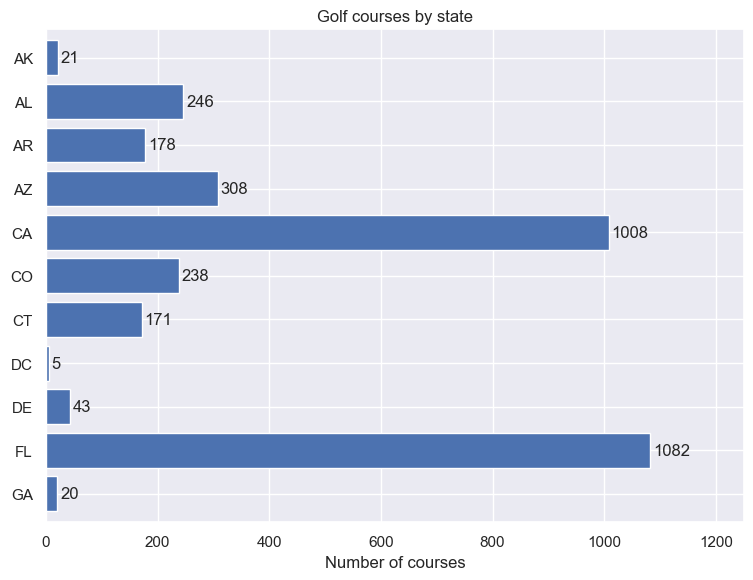

In [9]:
# Simple plot showing number of courses per state
counts = data.groupby('state').size()[::-1]
fig, ax = plt.subplots(1)
fig.set_size_inches(9, 2 + len(counts)* 0.4)
counts.plot(kind='barh', ax=ax, width=0.8)
for i, ct in enumerate(counts.values):
    ax.text(ct + 5, i, ct, ha='left', va='center')
ax.set_xlim(0, ax.get_xlim()[1] * 1.1)
ax.set_xlabel('Number of courses')
ax.set_ylabel('')
ax.set_title('Golf courses by state')